In [32]:
!pip install lazypredict

In [36]:
import optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lazypredict.Supervised import LazyRegressor

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor, VotingRegressor

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

In [37]:
df = pd.read_csv("data/train_data_cleaned.csv")
print(df.shape)
df.head()

(28218, 26)


,Promotion Name,Store Kind,Store Sales,Store Cost,Is Recyclable?,Store Area,Grocery Area,Frozen Area,Meat Area,Cost,...,Store Code,Country ISO2,Order Brand,Order,Department,Amenities Score,Gross Weight,Net Weight,Package Weight,Min. Person Yearly Income
0,Dimes Off,Deluxe,8760000.00,4292400.00,yes,2842.23,2037.64,481.98,323.00,602.76,...,H11go,ZA,Red Wing,Cleaning Supplies,Household,5,28.20,26.60,1.60,10000.00
1,Budget Bargains,Supermarket,6360000.00,1971600.00,no,2814.95,2049.72,457.36,304.98,708.66,...,S04ne,WA,Nationeel,Snack Foods,Snack Foods,0,16.57,14.97,1.60,50000.00
2,Shelf Emptiers,Supermarket,10860000.00,4452600.00,yes,2192.32,1322.21,523.32,348.85,564.26,...,L05es,CA,Excel,Magazines,Periodicals,1,28.64,27.18,1.45,30000.00
3,Sale Winners,Deluxe,11560000.00,4970800.00,no,2862.30,1872.19,593.93,395.95,519.76,...,M10da,YU,Hermanos,Vegetables,Produce,5,12.62,9.71,2.91,50000.00
4,Weekend Discount,Supermarket,5220000.00,1618200.00,yes,1970.17,1236.07,440.92,293.95,364.16,...,S03le,WA,Red Wing,Candles,Household,1,15.41,13.95,1.45,30000.00


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28218 entries, 0 to 28217
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Promotion Name             28218 non-null  object 
 1   Store Kind                 28218 non-null  object 
 2   Store Sales                28218 non-null  float64
 3   Store Cost                 28218 non-null  float64
 4   Is Recyclable?             28218 non-null  object 
 5   Store Area                 28218 non-null  float64
 6   Grocery Area               28218 non-null  float64
 7   Frozen Area                28218 non-null  float64
 8   Meat Area                  28218 non-null  float64
 9   Cost                       28218 non-null  float64
 10  Degree Work                28218 non-null  object 
 11  Marriage                   28218 non-null  object 
 12  Gender                     28218 non-null  object 
 13  Children                   28218 non-null  obj

In [39]:
df.isna().sum()

Promotion Name               0
Store Kind                   0
Store Sales                  0
Store Cost                   0
Is Recyclable?               0
Store Area                   0
Grocery Area                 0
Frozen Area                  0
Meat Area                    0
Cost                         0
Degree Work                  0
Marriage                     0
Gender                       0
Children                     0
Degree                       0
Work                         0
Store Code                   0
Country ISO2                 0
Order Brand                  0
Order                        0
Department                   0
Amenities Score              0
Gross Weight                 0
Net Weight                   0
Package Weight               0
Min. Person Yearly Income    0
dtype: int64

our data looks clean to model building!!

if you want to take a look on this data pre-processing you will find it by clicking on this [link](https://www.kaggle.com/code/kershrita/market-costs-data-preprocessing-guide)

# Feature Engineering

we dropped a column in pre-processing notebook called `Place Code` after splitting it so we will get it back because it add performance to the model

In [40]:
# Step 1
df["Store CountryISO2"] = df["Store Code"] + '_' + df["Country ISO2"]

we will create new column called `Income Level` that represents the classes of this persons based on there income:

- [0 -> 25,000] USD represents `Low` class
- [25,000 -> 50,000] USD represents `Middle` class
- [50,000 -> +inf] USD represents `High` class

In [41]:
# Step 2
df['Income Level'] = (
    pd.cut(
        df['Min. Person Yearly Income'],
        bins=[0, 25000, 50000, float('inf')],
        labels=['Low', 'Middle', 'High']
    )
    .astype("object")
)

like we did above with `Min. Person Yearly Income` column we will do to `Gross Weight`, we will calculate column called `Price Tier` that represents the classes of orders prices:

- [0 -> 5] Kg represents `Low Price` class
- [5 -> 10] Kg represents `Middle Price` class
- [10 -> +inf] Kg represents `High Price` class

In [42]:
# Step 3
df['Price Tier'] = (
    pd.cut(
        df['Gross Weight'],
        bins=[0, 5, 10, float('inf')],
        labels=['Low Price', 'Medium Price', 'High Price']
    )
    .astype("object")
)

we can calculate from `Order` column the popularity of each product in the whole dataset 

In [43]:
# Step 4
order_popularity = df['Order'].value_counts().reset_index()
order_popularity.columns = ['Order', 'Order Popularity']
df = df.merge(order_popularity, on='Order', how='left')

from `Min. Person Yearly Income` column & `Children` we can extract something it maybe important for our model, a column we will name `Family Expenses` that represents the expenses of each person in the family based on `Min. Person Yearly Income` column

In [44]:
# Step 5
def calculate_family_expenses(row):
    if row["Marriage"] == "Married":
        return row["Min. Person Yearly Income"] / (row["Children"] + 2)
    else:
        return row["Min. Person Yearly Income"] / (row["Children"] + 1)

children_mapping = {
    'No': 0,
    'one': 1,
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5
}

temp_df = df.copy()
temp_df['Children'] = temp_df['Children'].map(children_mapping)
temp_df["Family Expenses"] = temp_df.apply(lambda row: calculate_family_expenses(row), axis=1)

df["Family Expenses"] = temp_df["Family Expenses"]

now let's gooooo with our king column, we will concat it with every info about the person like `Gender`, `Marriage`, `Children`, etc.. then calculate `Promotion Name Length` column

In [45]:
# Step 6
person_description = ["Gender", "Marriage", "Children", "Degree"]
for col in person_description:
    df['Promotion '+ col] = df['Promotion Name'] + ' ' + df[col]
    
df['Promotion Name Length'] = (df['Promotion Name'].apply(lambda x: len(x))).astype(int)

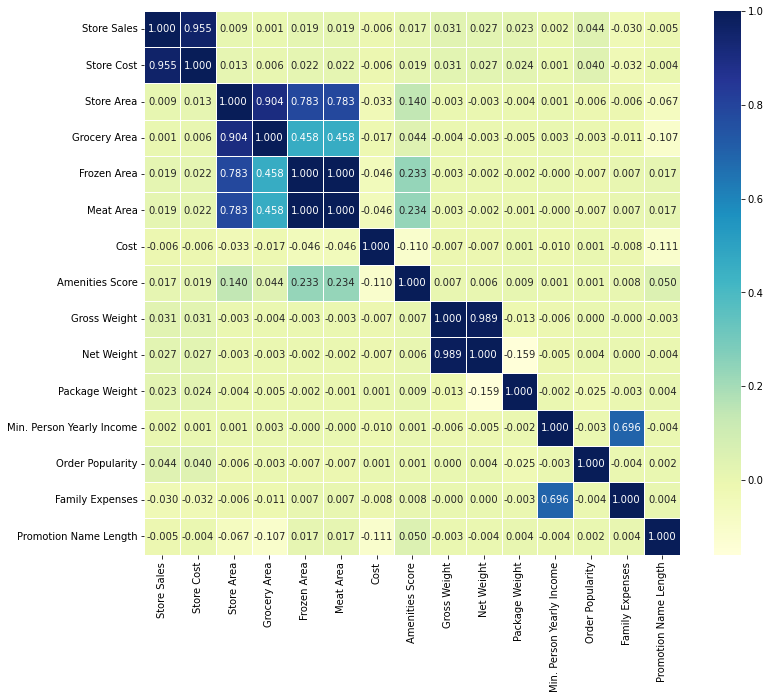

In [11]:
plt.figure(figsize=(12, 10)) 
sns.heatmap(df.select_dtypes("number").corr(), cmap='YlGnBu', annot=True, fmt='.3f', linewidths=0.5);

Hmmmmmm?

there is a lot of **multilinearity** columns above we need to drop some of them to improve our model performance

In [57]:
# Step 7
df.drop(columns=["Store Sales", "Frozen Area", "Net Weight", "Store Area", 'Is Recyclable?'], inplace = True)

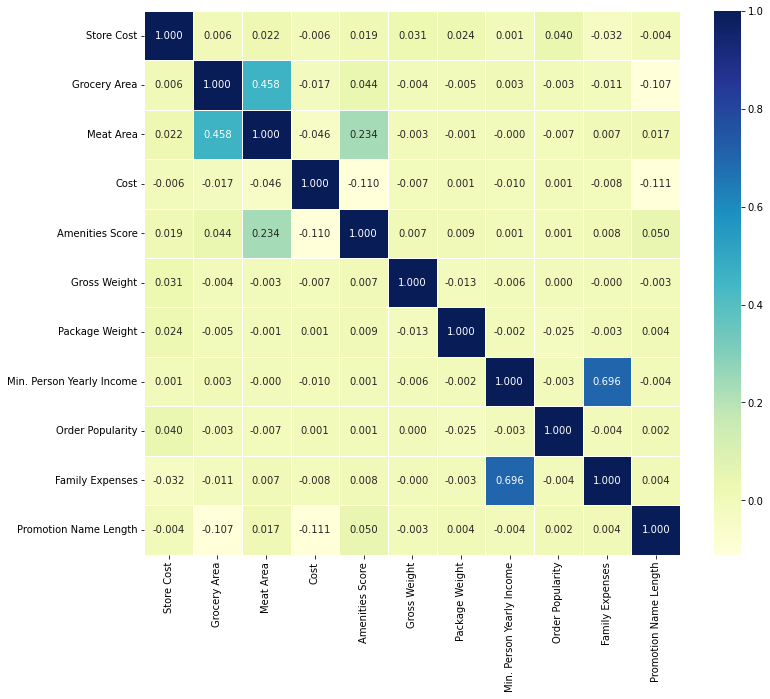

In [13]:
plt.figure(figsize=(12, 10)) 
sns.heatmap(df.select_dtypes("number").corr(), cmap='YlGnBu', annot=True, fmt='.3f', linewidths=0.5);

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28218 entries, 0 to 28217
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Promotion Name             28218 non-null  object 
 1   Store Kind                 28218 non-null  object 
 2   Store Cost                 28218 non-null  float64
 3   Grocery Area               28218 non-null  float64
 4   Meat Area                  28218 non-null  float64
 5   Cost                       28218 non-null  float64
 6   Degree Work                28218 non-null  object 
 7   Marriage                   28218 non-null  object 
 8   Gender                     28218 non-null  object 
 9   Children                   28218 non-null  object 
 10  Degree                     28218 non-null  object 
 11  Work                       28218 non-null  object 
 12  Store Code                 28218 non-null  object 
 13  Country ISO2               28218 non-null  obj

now everything is clear, we need to create a function that includes all this features engineering to handle test data after model building

In [46]:
def apply_feature_engineering(df):
    # Step 1
    df["Store CountryISO2"] = df["Store Code"] + '_' + df["Country ISO2"]
    
    # Step 2
    df['Income Level'] = (
        pd.cut(
            df['Min. Person Yearly Income'],
            bins=[0, 25000, 50000, float('inf')],
            labels=['Low', 'Middle', 'High']
        )
        .astype("object")
    )
    
    # Step 3
    df['Price Tier'] = (
        pd.cut(
            df['Gross Weight'],
            bins=[0, 5, 10, float('inf')],
            labels=['Low Price', 'Medium Price', 'High Price']
        )
        .astype("object")
    )
    
    # Step 4
    order_popularity = df['Order'].value_counts().reset_index()
    order_popularity.columns = ['Order', 'Order Popularity']
    df = df.merge(order_popularity, on='Order', how='left')
    
    # Step 5
    def calculate_family_expenses(row):
        if row["Marriage"] == "Married":
            return row["Min. Person Yearly Income"] / (row["Children"] + 2)
        else:
            return row["Min. Person Yearly Income"] / (row["Children"] + 1)

    children_mapping = {
        'No': 0,
        'one': 1,
        'two': 2,
        'three': 3,
        'four': 4,
        'five': 5
    }

    temp_df = df.copy()
    temp_df['Children'] = temp_df['Children'].map(children_mapping)
    temp_df["Family Expenses"] = temp_df.apply(lambda row: calculate_family_expenses(row), axis=1)
    df["Family Expenses"] = temp_df["Family Expenses"]
    
    # Step 6
    person_description = ["Gender", "Marriage", "Children", "Degree"]
    for col in person_description:
        df['Promotion '+ col] = df['Promotion Name'] + ' ' + df[col]

    df['Promotion Name Length'] = (df['Promotion Name'].apply(lambda x: len(x))).astype(int)
    
    # Step 7
    df.drop(columns=["Store Sales", "Frozen Area", "Net Weight", "Store Area", 'Is Recyclable?'], inplace = True)
    
    return df

# Model Building

## Data Splitting

In [58]:
target = "Cost"
X = df.drop(columns=target)
y = df[target]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Transformation

In [60]:
categorical_columns = df.select_dtypes("object").columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_columns),
    ]
)

In [61]:
preprocessor.fit(X_train)

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

## Try Lazypredict

In [53]:
reg = LazyRegressor(verbose=1,ignore_warnings=False, custom_metric=None)
models,predictions = reg.fit(X_train_transformed, X_test_transformed, y_train, y_test)

  2%|▏         | 1/42 [00:00<00:29,  1.39it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.14926661792903395, 'Adjusted R-Squared': 0.14608885182738152, 'RMSE': 144.98876604325787, 'Time taken': 0.7171630859375}


  5%|▍         | 2/42 [00:01<00:37,  1.07it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.894793221432387, 'Adjusted R-Squared': 0.8944002398689008, 'RMSE': 50.98700215497209, 'Time taken': 1.0833072662353516}


  7%|▋         | 3/42 [00:02<00:23,  1.65it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.016937146299012773, 'Adjusted R-Squared': 0.013265086546661142, 'RMSE': 155.8576987250082, 'Time taken': 0.21093034744262695}


 14%|█▍        | 6/42 [00:02<00:09,  3.70it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8386175329664859, 'Adjusted R-Squared': 0.8380147169210032, 'RMSE': 63.14890023997532, 'Time taken': 0.2758193016052246}
{'Model': 'DummyRegressor', 'R-Squared': -0.00022511450858475612, 'Adjusted R-Squared': -0.0039612808914877284, 'RMSE': 157.2122900585577, 'Time taken': 0.03204774856567383}
{'Model': 'ElasticNet', 'R-Squared': 0.014738115822016118, 'Adjusted R-Squared': 0.011057841975033234, 'RMSE': 156.03192175378658, 'Time taken': 0.1425304412841797}


 19%|█▉        | 8/42 [00:04<00:18,  1.80it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.017325335577310974, 'Adjusted R-Squared': 0.013654725838272097, 'RMSE': 155.82692334717598, 'Time taken': 1.8409037590026855}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.87723074146347, 'Adjusted R-Squared': 0.8767721583205907, 'RMSE': 55.078541687962705, 'Time taken': 0.16437673568725586}


 24%|██▍       | 10/42 [00:11<00:51,  1.62s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9214100279719897, 'Adjusted R-Squared': 0.921116468844884, 'RMSE': 44.067781110150285, 'Time taken': 6.38057279586792}
{'Model': 'GammaRegressor', 'R-Squared': 0.01345359547884295, 'Adjusted R-Squared': 0.009768523530258033, 'RMSE': 156.1336007580143, 'Time taken': 0.12900519371032715}


 26%|██▌       | 11/42 [06:41<59:48, 115.74s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.9677609506564995, 'Adjusted R-Squared': -0.9751111783270412, 'RMSE': 220.50771323464585, 'Time taken': 390.46442914009094}


 29%|██▊       | 12/42 [06:46<41:27, 82.91s/it] 

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.46483339821221925, 'Adjusted R-Squared': 0.46283437675410055, 'RMSE': 114.99583677026202, 'Time taken': 4.584687948226929}


 31%|███       | 13/42 [06:47<28:19, 58.61s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8426342548565232, 'Adjusted R-Squared': 0.8420464425747707, 'RMSE': 62.358077545033936, 'Time taken': 1.036191463470459}


 33%|███▎      | 14/42 [06:48<19:20, 41.44s/it]

{'Model': 'HuberRegressor', 'R-Squared': 0.017152221937549283, 'Adjusted R-Squared': 0.013480965562716274, 'RMSE': 155.84064842776627, 'Time taken': 0.9271109104156494}


 36%|███▌      | 15/42 [06:48<13:11, 29.32s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.15477373367891845, 'Adjusted R-Squared': 0.15161653844719614, 'RMSE': 144.51872082578893, 'Time taken': 0.8339033126831055}


 40%|████      | 17/42 [09:10<18:20, 44.00s/it]

{'Model': 'KernelRidge', 'R-Squared': -10.99060586479074, 'Adjusted R-Squared': -11.035394680721122, 'RMSE': 544.3248735805114, 'Time taken': 141.04116535186768}
{'Model': 'Lars', 'R-Squared': -421957.37617675355, 'Adjusted R-Squared': -423533.52806215227, 'RMSE': 102110.97490877924, 'Time taken': 0.1714038848876953}


 43%|████▎     | 18/42 [09:10<12:23, 30.98s/it]

{'Model': 'LarsCV', 'R-Squared': 0.015721189216443165, 'Adjusted R-Squared': 0.012044587468585721, 'RMSE': 155.9540596568909, 'Time taken': 0.5097432136535645}


 45%|████▌     | 19/42 [09:11<08:23, 21.89s/it]

{'Model': 'Lasso', 'R-Squared': 0.016338659601611516, 'Adjusted R-Squared': 0.012664364306633535, 'RMSE': 155.90513443390654, 'Time taken': 0.6364762783050537}


 50%|█████     | 21/42 [09:13<03:57, 11.32s/it]

{'Model': 'LassoCV', 'R-Squared': 0.017864792477625846, 'Adjusted R-Squared': 0.014196197785706688, 'RMSE': 155.7841454817798, 'Time taken': 2.5382907390594482}
{'Model': 'LassoLars', 'R-Squared': 0.01634244540836871, 'Adjusted R-Squared': 0.012668164254611258, 'RMSE': 155.9048344184159, 'Time taken': 0.16628289222717285}


 52%|█████▏    | 22/42 [09:14<02:41,  8.08s/it]

{'Model': 'LassoLarsCV', 'R-Squared': 0.018679808419840405, 'Adjusted R-Squared': 0.015014258077758691, 'RMSE': 155.71949404041766, 'Time taken': 0.5157420635223389}


 55%|█████▍    | 23/42 [09:14<01:49,  5.77s/it]

{'Model': 'LassoLarsIC', 'R-Squared': 0.0199630142822933, 'Adjusted R-Squared': 0.016302257131800335, 'RMSE': 155.61764882469177, 'Time taken': 0.35338687896728516}


 60%|█████▉    | 25/42 [09:15<00:49,  2.92s/it]

{'Model': 'LinearRegression', 'R-Squared': 0.019579688204302448, 'Adjusted R-Squared': 0.015917499206132835, 'RMSE': 155.6480795492381, 'Time taken': 0.2058703899383545}
{'Model': 'LinearSVR', 'R-Squared': 0.009603163483534294, 'Adjusted R-Squared': 0.005903708918104655, 'RMSE': 156.43799412302135, 'Time taken': 0.16242146492004395}


 62%|██████▏   | 26/42 [10:38<07:12, 27.06s/it]

{'Model': 'MLPRegressor', 'R-Squared': 0.14560470922261648, 'Adjusted R-Squared': 0.14241326469996884, 'RMSE': 145.3004768098407, 'Time taken': 83.38418531417847}


 64%|██████▍   | 27/42 [11:15<07:30, 30.00s/it]

{'Model': 'NuSVR', 'R-Squared': 0.04317428834334991, 'Adjusted R-Squared': 0.039600232856905726, 'RMSE': 153.76377583322375, 'Time taken': 36.85495042800903}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.015466098630286917, 'Adjusted R-Squared': 0.011788544036056448, 'RMSE': 155.9742672621129, 'Time taken': 0.08967804908752441}


 71%|███████▏  | 30/42 [11:16<02:27, 12.27s/it]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.015807264260297882, 'Adjusted R-Squared': 0.012130984030747305, 'RMSE': 155.94724042748845, 'Time taken': 0.3351895809173584}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.03743296875449076, 'Adjusted R-Squared': -0.04130811858441685, 'RMSE': 160.10969830104645, 'Time taken': 0.19414329528808594}


 76%|███████▌  | 32/42 [11:16<01:06,  6.69s/it]

{'Model': 'PoissonRegressor', 'R-Squared': 0.017702358500569004, 'Adjusted R-Squared': 0.01403315706487207, 'RMSE': 155.79702741083142, 'Time taken': 0.3054518699645996}
QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


 79%|███████▊  | 33/42 [11:17<00:46,  5.22s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.3723400891484503, 'Adjusted R-Squared': -0.3774662260876387, 'RMSE': 184.1486297417403, 'Time taken': 1.4358501434326172}


 81%|████████  | 34/42 [11:28<00:54,  6.77s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.904915764861129, 'Adjusted R-Squared': 0.9045605942923072, 'RMSE': 48.47210443071319, 'Time taken': 10.641420602798462}
{'Model': 'Ridge', 'R-Squared': 0.019394814248193892, 'Adjusted R-Squared': 0.015731934685620508, 'RMSE': 155.6627538269427, 'Time taken': 0.08595418930053711}


 86%|████████▌ | 36/42 [11:29<00:22,  3.81s/it]

{'Model': 'RidgeCV', 'R-Squared': 0.01959073161254543, 'Adjusted R-Squared': 0.01592858386510032, 'RMSE': 155.64720294044878, 'Time taken': 0.2921578884124756}


 88%|████████▊ | 37/42 [11:29<00:14,  2.95s/it]

{'Model': 'SGDRegressor', 'R-Squared': 0.009999000506197953, 'Adjusted R-Squared': 0.006301024520895648, 'RMSE': 156.40672880787452, 'Time taken': 0.2592496871948242}


 93%|█████████▎| 39/42 [12:04<00:24,  8.33s/it]

{'Model': 'SVR', 'R-Squared': 0.04353370938167034, 'Adjusted R-Squared': 0.039960996449798225, 'RMSE': 153.73489328634102, 'Time taken': 35.518821477890015}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.019579688204302448, 'Adjusted R-Squared': 0.015917499206132835, 'RMSE': 155.6480795492381, 'Time taken': 0.1288595199584961}


 95%|█████████▌| 40/42 [12:05<00:12,  6.07s/it]

{'Model': 'TweedieRegressor', 'R-Squared': 0.013463349336111263, 'Adjusted R-Squared': 0.009778313821358187, 'RMSE': 156.13282891970348, 'Time taken': 0.1975085735321045}


 98%|█████████▊| 41/42 [12:08<00:05,  5.42s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.8922070356856087, 'Adjusted R-Squared': 0.8918043938765368, 'RMSE': 51.60987700612608, 'Time taken': 3.7723770141601562}


100%|██████████| 42/42 [12:09<00:00, 17.38s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.8364330103086377, 'Adjusted R-Squared': 0.8358220343599506, 'RMSE': 63.57486504569401, 'Time taken': 0.9536614418029785}


In [54]:
print(models)

                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
ExtraTreesRegressor                          0.92       0.92     44.07   
RandomForestRegressor                        0.90       0.90     48.47   
BaggingRegressor                             0.89       0.89     50.99   
XGBRegressor                                 0.89       0.89     51.61   
ExtraTreeRegressor                           0.88       0.88     55.08   
HistGradientBoostingRegressor                0.84       0.84     62.36   
DecisionTreeRegressor                        0.84       0.84     63.15   
LGBMRegressor                                0.84       0.84     63.57   
GradientBoostingRegressor                    0.46       0.46    115.00   
KNeighborsRegressor                          0.15       0.15    144.52   
AdaBoostRegressor                            0.15       0.15    144.99   
MLPRegressor                          

that is really good

we will choose `ExtraTreesRegressor` & `RandomForestRegressor`, our best two models

## Try CatBoost

In [69]:
cat = CatBoostRegressor(
    iterations=1000,
    depth=8,
    random_state=42,
    loss_function='RMSE',
    verbose=10
)
cat.fit(
    X_train,
    y_train,
    cat_features=list((list(X_train.select_dtypes("object").columns))),
    eval_set=(X_test, y_test),
)

Learning rate set to 0.083064
0:	learn: 148.4060702	test: 148.5033314	best: 148.5033314 (0)	total: 256ms	remaining: 4m 16s
10:	learn: 93.1758160	test: 92.9139023	best: 92.9139023 (10)	total: 1.29s	remaining: 1m 56s
20:	learn: 73.2642941	test: 72.4283715	best: 72.4283715 (20)	total: 2.48s	remaining: 1m 55s
30:	learn: 65.3547486	test: 64.1471732	best: 64.1471732 (30)	total: 3.64s	remaining: 1m 53s
40:	learn: 60.8334562	test: 59.2543463	best: 59.2543463 (40)	total: 4.85s	remaining: 1m 53s
50:	learn: 57.6569586	test: 55.9736475	best: 55.9736475 (50)	total: 6.08s	remaining: 1m 53s
60:	learn: 55.7102727	test: 53.9785523	best: 53.9785523 (60)	total: 7.28s	remaining: 1m 52s
70:	learn: 55.0129371	test: 53.4323027	best: 53.4323027 (70)	total: 8.46s	remaining: 1m 50s
80:	learn: 54.5272927	test: 53.0413986	best: 53.0413986 (80)	total: 9.6s	remaining: 1m 48s
90:	learn: 53.8149329	test: 52.5511936	best: 52.5511936 (90)	total: 10.8s	remaining: 1m 47s
100:	learn: 53.1353010	test: 51.9859049	best: 51.9

880:	learn: 34.8072681	test: 45.7777283	best: 45.7352395 (838)	total: 2m 12s	remaining: 17.9s
890:	learn: 34.6835639	test: 45.7805521	best: 45.7352395 (838)	total: 2m 14s	remaining: 16.4s
900:	learn: 34.5632489	test: 45.7441814	best: 45.7352395 (838)	total: 2m 15s	remaining: 14.9s
910:	learn: 34.4313273	test: 45.7204365	best: 45.7121931 (905)	total: 2m 17s	remaining: 13.4s
920:	learn: 34.2268106	test: 45.6932415	best: 45.6892625 (918)	total: 2m 18s	remaining: 11.9s
930:	learn: 34.0846090	test: 45.6279894	best: 45.6279894 (930)	total: 2m 19s	remaining: 10.4s
940:	learn: 33.8785366	test: 45.6171953	best: 45.6057998 (938)	total: 2m 21s	remaining: 8.87s
950:	learn: 33.7132978	test: 45.5847327	best: 45.5847327 (950)	total: 2m 23s	remaining: 7.38s
960:	learn: 33.5117213	test: 45.5477273	best: 45.5477273 (960)	total: 2m 24s	remaining: 5.87s
970:	learn: 33.4004180	test: 45.5459267	best: 45.5396283 (963)	total: 2m 26s	remaining: 4.37s
980:	learn: 33.2516572	test: 45.5213168	best: 45.5213168 (98

In [93]:
def plot_feature_importance(importances, columns, top_n):
    feat_imp = pd.Series(importances, index=columns).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(range(top_n), feat_imp[:top_n], align='center')
    plt.xticks(range(top_n), feat_imp.index[:top_n], rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Feature Importance')
    plt.title('Top {} Feature Importances'.format(top_n))
    plt.tight_layout()
    plt.show()

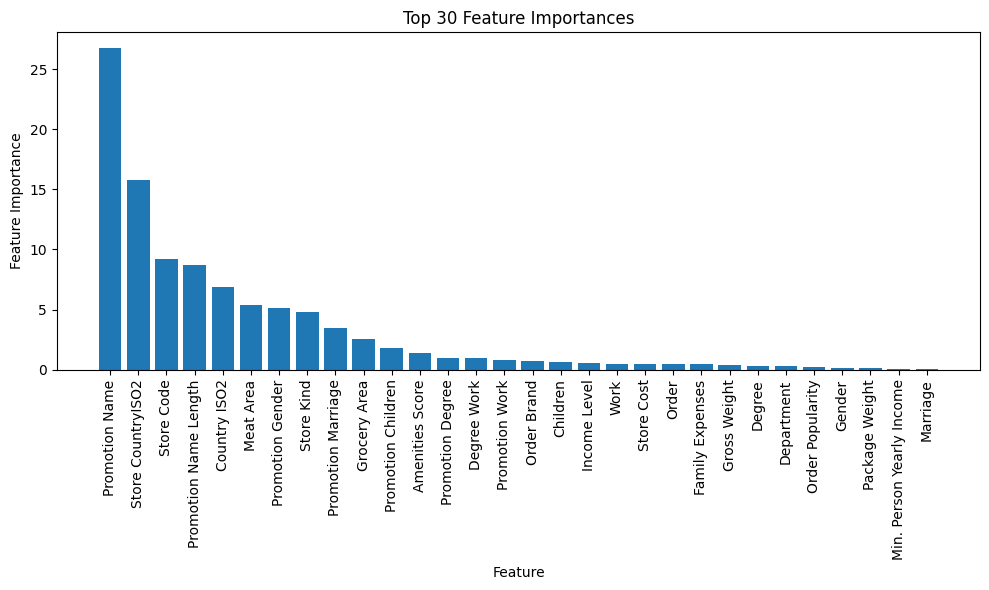

In [94]:
plot_feature_importance(cat.get_feature_importance(), X_train.columns, 30)

## Hyperparameter Tunning using GridSearch

### ExtraTrees

In [ ]:
params = {
    'n_estimators': range(100, 1001, 100),
    'max_depth': [6, 12, 18, 24, 30]
}

gs_ex = GridSearchCV(
    ExtraTreesRegressor(random_state=42, n_jobs=-1),
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

gs_ex.fit(X_train_transformed, y_train)
gs_ex.best_params_

In [62]:
exmodel = make_pipeline(
    preprocessor,
    ExtraTreesRegressor(n_estimators=350, max_depth=16, n_jobs=-1, random_state=42)
)
exmodel.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  Index(['Promotion Name', 'Store Kind', 'Degree Work', 'Marriage', 'Gender',
       'Children', 'Degree', 'Work', 'Store Code', 'Country ISO2',
       'Order Brand', 'Order', 'Department', 'Store CountryISO2',
       'Income Level', 'Price Tier', 'Promotion Gender', 'Promotion Marriage',
       'Promotion Children', 'Promotion Degree'],
      dtype='object'))])),
                ('extratreesregressor',
                 ExtraTreesRegressor(max_depth=16, n_estimators=350, n_jobs=-1,
                                     random_state=42))])

In [63]:
y_train_pred = exmodel.predict(X_train)
y_test_pred = exmodel.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"train: {train_rmse}, test: {test_rmse}")

train: 22.45830917125754, test: 44.23338400674494


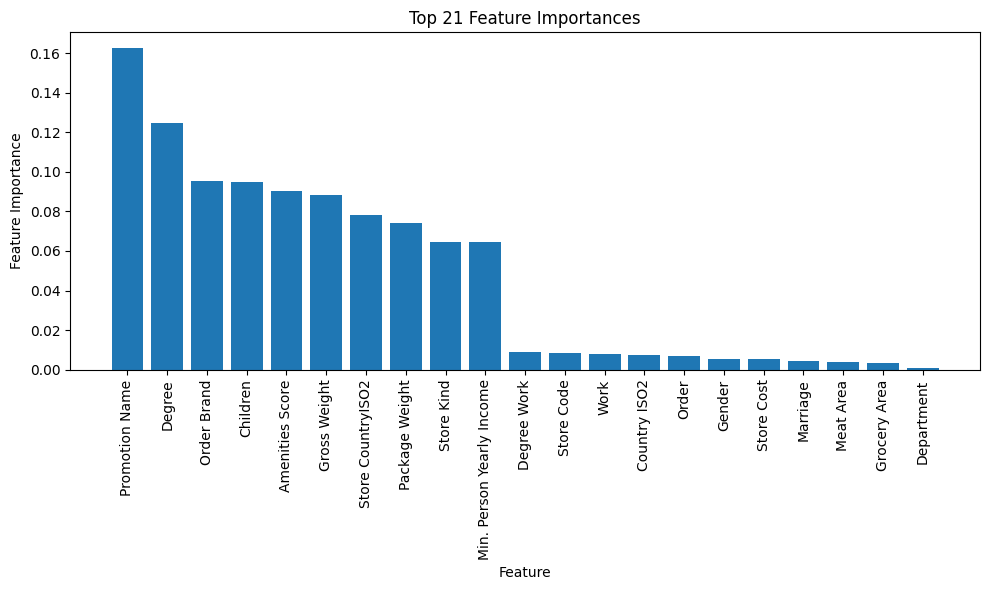

In [97]:
plot_feature_importance(exmodel.named_steps["extratreesregressor"].feature_importances_, X_train.columns[:21], 21)

### RandomForest

In [ ]:
params = {
    'n_estimators': range(100, 1001, 100),
    'max_depth': [6, 12, 18, 24, 30]
}

gs_rf = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

gs_rf.fit(X_train_transformed, y_train)

In [65]:
rfmodel = make_pipeline(
    preprocessor,
    RandomForestRegressor(n_estimators=400, max_depth=24, n_jobs=-1, random_state=42)
)
rfmodel.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  Index(['Promotion Name', 'Store Kind', 'Degree Work', 'Marriage', 'Gender',
       'Children', 'Degree', 'Work', 'Store Code', 'Country ISO2',
       'Order Brand', 'Order', 'Department', 'Store CountryISO2',
       'Income Level', 'Price Tier', 'Promotion Gender', 'Promotion Marriage',
       'Promotion Children', 'Promotion Degree'],
      dtype='object'))])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=24, n_estimators=400,
                                       n_jobs=-1, random_state=42))])

In [54]:
y_train_pred = rfmodel.predict(X_train)
y_test_pred = rfmodel.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"train: {train_rmse}, test: {test_rmse}")

train: 17.66017088494734, test: 48.26289816471192


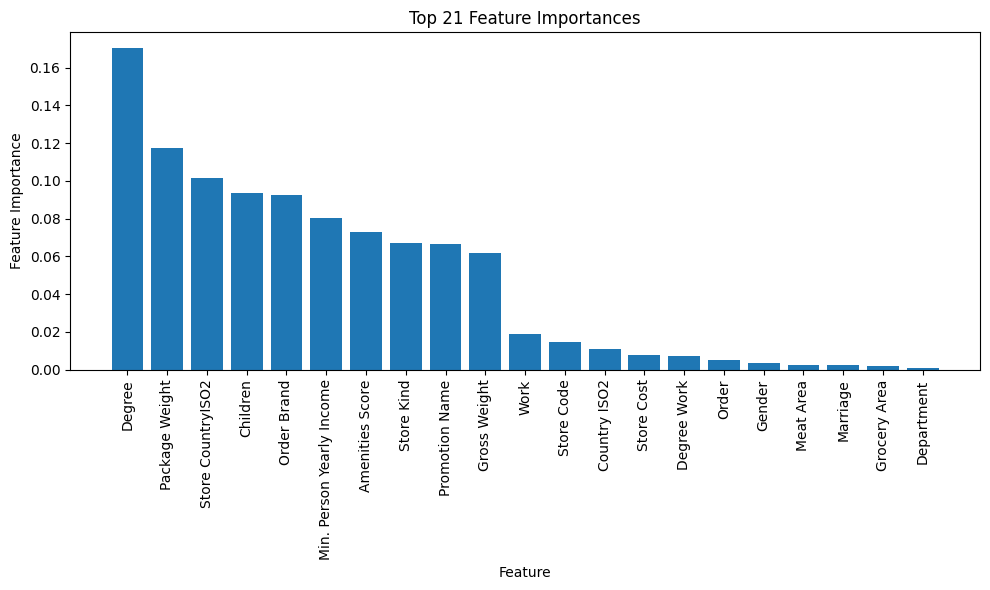

In [114]:
plot_feature_importance(rfmodel.named_steps["randomforestregressor"].feature_importances_, X_train.columns[:21], 21)

### Ensemble Voting

In [67]:
estimators = [
              ('rf', rfmodel),
              ('et', exmodel),
             ]

voting_model = VotingRegressor(estimators=estimators)

voting_model.fit(X_train, y_train)

VotingRegressor(estimators=[('rf',
                             Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OrdinalEncoder(),
                                                                               Index(['Promotion Name', 'Store Kind', 'Degree Work', 'Marriage', 'Gender',
       'Children', 'Degree', 'Work', 'Store Code', 'Country ISO2',
       'Order Brand', 'Order', 'Department', 'Store CountryISO2',
       'Income Level', 'Price Tier', 'Promotion Gender', 'Prom...
                                                                               Index(['Promotion Name', 'Store Kind', 'Degree Work', 'Marriage', 'Gender',
       'Children', 'Degree', 'Work', 'Store Code', 'Country ISO2',
       'Order Brand', 'Order', 'Department', 'Store CountryISO2',
       'Income Level', 'Price Tier', 'Promotion Gender', 'Promotion Marri

In [25]:
y_train_pred = voting_model.predict(X_train)
y_test_pred = voting_model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"train: {train_rmse}, test: {test_rmse}")

train: 19.206496473900916, test: 45.41333102080629


In [124]:
voting_model.score(X_test, y_test)

0.91669856779416

# Extract submissions

In [32]:
samples = pd.read_csv('data/sample_submission.csv')

test = pd.read_csv("data/test_data_cleaned.csv")

test = apply_feature_engineering(test)
print(test.shape)
test.head()

(19942, 31)


,Promotion Name,Store Kind,Store Cost,Grocery Area,Meat Area,Degree Work,Marriage,Gender,Children,Degree,...,Income Level,Price Tier,Order Popularity,Family Expenses,Promotion Gender,Promotion Marriage,Promotion Children,Promotion Degree,Promotion Work,Promotion Name Length
0,Fantastic Discounts,Gourmet,4704000.00,1424.85,308.73,partial high school working as skilled manual,Single,Male,four,partial high school,...,Middle,High Price,485,10000.00,Fantastic Discounts Male,Fantastic Discounts Single,Fantastic Discounts four,Fantastic Discounts partial high school,Fantastic Discounts skilled manual,19
1,Bag Stuffer,Deluxe,669600.00,1735.17,336.59,graduate degree working as professional,Married,Female,three,graduate degree,...,High,High Price,2337,14000.00,Bag Stuffer Female,Bag Stuffer Married,Bag Stuffer three,Bag Stuffer graduate degree,Bag Stuffer professional,11
2,Pick Your Savings,Deluxe,823500.00,2038.11,321.26,partial high school working as management,Single,Female,three,partial high school,...,High,High Price,1292,32500.00,Pick Your Savings Female,Pick Your Savings Single,Pick Your Savings three,Pick Your Savings partial high school,Pick Your Savings management,17
3,Price Winners,Deluxe,4410000.00,1871.16,394.58,partial high school working as manual,Single,Male,three,partial high school,...,Low,High Price,476,2500.00,Price Winners Male,Price Winners Single,Price Winners three,Price Winners partial high school,Price Winners manual,13
4,Dollar Days,Supermarket,1987200.00,1320.15,348.85,high school degree working as manual,Single,Male,two,high school degree,...,Middle,High Price,308,10000.00,Dollar Days Male,Dollar Days Single,Dollar Days two,Dollar Days high school degree,Dollar Days manual,11


In [33]:
test.isna().sum()

Promotion Name               0
Store Kind                   0
Store Cost                   0
Grocery Area                 0
Meat Area                    0
Degree Work                  0
Marriage                     0
Gender                       0
Children                     0
Degree                       0
Work                         0
Store Code                   0
Country ISO2                 0
Order Brand                  0
Order                        0
Department                   0
Amenities Score              0
Gross Weight                 0
Package Weight               0
Min. Person Yearly Income    0
Store CountryISO2            0
Income Level                 0
Price Tier                   0
Order Popularity             0
Family Expenses              0
Promotion Gender             0
Promotion Marriage           0
Promotion Children           0
Promotion Degree             0
Promotion Work               0
Promotion Name Length        0
dtype: int64

In [71]:
y_sub_pred = exmodel.predict(test)
samples["Cost"] = y_sub_pred
samples.to_csv("data/submission.csv", index=False)